In [1]:
!nvcc --version
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:36:24_Pacific_Standard_Time_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7864528067124046574
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4185718784
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3821245987786263710
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet_v2 import ResNet152V2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
import os

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

## 1- Image Acquisition :

In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = 128
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\\Users\\Lenovo\\uni\\GRAD PROJECT\\dermnet1\\train",labels='inferred',
    #label_mode='categorical',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\\Users\\Lenovo\\uni\\GRAD PROJECT\\dermnet1\\test",labels='inferred',
    #label_mode='categorical',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE  
)

Found 8358 files belonging to 8 classes.
Found 2139 files belonging to 8 classes.


In [5]:
class_names = train_dataset.class_names

In [6]:
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split

# encoder = LabelEncoder()
# y = np_utils.to_categorical(encoder.fit_transform(df["Class"]))
# scaler = StandardScaler()
# X, y = shuffle(audios, y)


In [51]:
train_data_dir = 'C:\\Users\\Lenovo\\uni\\GRAD PROJECT\\dermnet1\\train'
train_datagen = ImageDataGenerator(
					#rescale=1./255,
					rotation_range=180,
					zoom_range=0.2,
					horizontal_flip=True,
                    vertical_flip=True,
					fill_mode='nearest')



train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='rgb',
					target_size=(128,128),
					batch_size=128,
					class_mode='binary',
					shuffle=True)

Found 8358 images belonging to 8 classes.


In [7]:
def get_dataset_partitions_tf(ds, train_split = 0.95,val_split = 0.05,shuffle = True,shuffle_size = 11988):
    assert(train_split+val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    return train_ds, val_ds

In [8]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [9]:
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
# labelsTrain =  np.array([])
# for _, y in train_ds:
#  labelsTrain = np.concatenate([labelsTrain, np.argmax(y.numpy(), axis=-1)])

# labelsTest =  np.array([])
# for _, y in test_dataset:
#  labelsTest = np.concatenate([labelsTest, np.argmax(y.numpy(), axis=-1)])

# labelsVal =  np.array([])
# for _, y in val_ds:
#  labelsVal = np.concatenate([labelsVal, np.argmax(y.numpy(), axis=-1)])


# #print(np.size(labelsTest),np.size(labelsVal),np.size(labelsTrain))



In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [339]:
num_classes = 24
img_rows,img_cols = 128,128
batch_size = 128
train_data_dir = 'C:\\Users\\Lenovo\\uni\\GRAD PROJECT\\dermnet2\\train\\Bacteria'
val_data_dir = 'C:\\Users\\Lenovo\\uni\\GRAD PROJECT\\dermnet2\\val'

train_datagen = ImageDataGenerator(
					rotation_range=30,
					shear_range=0.3,
					width_shift_range=0.4,
					height_shift_range=0.4,
					horizontal_flip=True,
					fill_mode='nearest',
)

# val_datagen = ImageDataGenerator(
# 					rescale=1./255,
# 					rotation_range=30,
# 					shear_range=0.3,
# 					zoom_range=0.3,
# 					width_shift_range=0.4,
# 					height_shift_range=0.4,
# 					horizontal_flip=True,
# 					fill_mode='nearest',
#     preprocessing_function=lambda x: x[..., np.random.permutation([0, 1, 2])]
# )

train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='rgb',
					target_size=(img_rows,img_cols),
					batch_size=32,
					class_mode='categorical',
					shuffle=True,
                    save_to_dir='C:\\Users\\Lenovo\\uni\\GRAD PROJECT\\dermnet2\\augmented\\test\\Bacterial Infections',
                    save_format='jpg'
)
for i in range(11):
    x = train_generator.next()

# validation_generator = val_datagen.flow_from_directory(
# 							val_data_dir,
# 							color_mode='rgb',
# 							target_size=(img_rows,img_cols),
# 							batch_size=batch_size,
# 							class_mode='categorical',
# 							shuffle=True)


Found 345 images belonging to 1 classes.


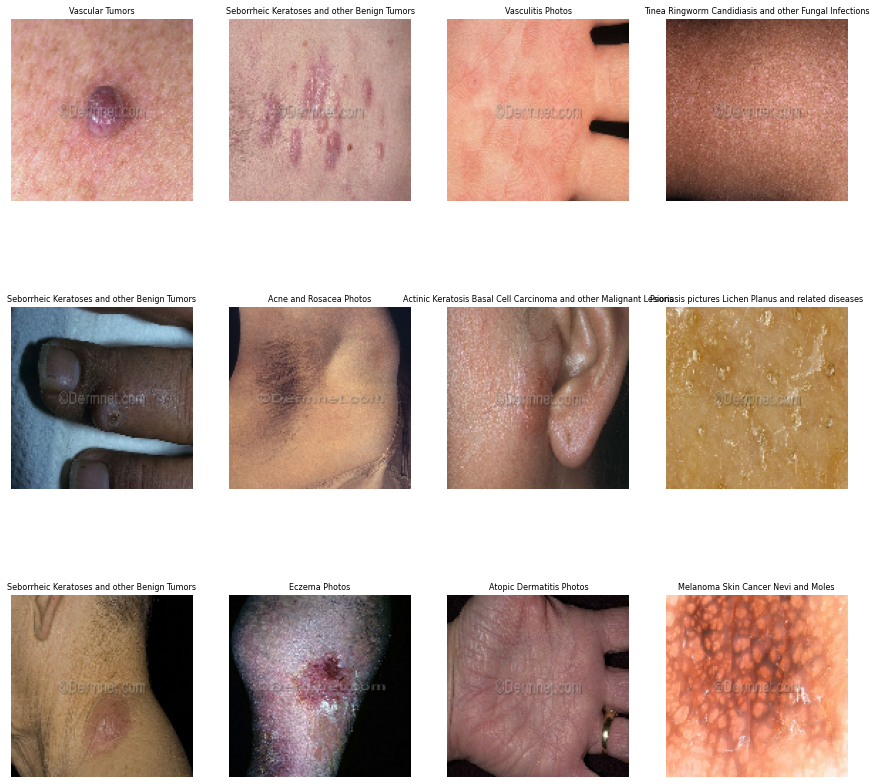

In [276]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]],fontsize = 8)
        plt.axis("off")
      #  print(image_batch.shape[0].shape)train_generator[1][1]

## 2- Architecture Load

In [13]:
from keras import backend as K

In [56]:
from keras.layers import Input, Conv1D, Conv2D,BatchNormalization, MaxPooling1D,MaxPooling2D, LSTM, Dense, Activation, Layer,Reshape
num_classes=8
base_model = Sequential()
base_model.add(MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
base_model.trainable = True
x=base_model.output
base_model.add(Dropout(0.5))
x=Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
base_model.add(Dropout(0.5))
x=Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x=MaxPooling2D()(x)
x=Flatten()(x)
x=x=BatchNormalization()(x)
#base_model.add(Dropout(0.4))
base_model.add(Dropout(0.4))
x=Dense(256,activation='relu')(x)   # FC layer 2
x=Dense(256,activation='relu')(x)   # FC layer 2
base_model.add(Dropout(0.5))
x=Dense(128,activation='relu')(x)   # FC layer 2
base_model.add(Dropout(0.5))
x=Dense(32,activation='relu')(x)   # FC layer 2
x=Dense(32,activation='relu')(x)   # FC layer 2
base_model.add(Dropout(0.4))
x=Dense(16,activation='relu')(x)   # FC layer 2
base_model.add(Dropout(0.5))
x=Dense(16,activation='relu')(x)   # FC layer 2
x=Dense(16,activation='relu')(x)   # FC layer 2
base_model.add(Dropout(0.5))
out=Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=out)

In [747]:
from tensorflow.keras.applications import ResNet50
base_model2 = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet")

for layer in base_model2.layers[:150]:
    layer.trainable = False
y=Flatten()(base_model2.output)
y=Dropout(0.5)(y)
y=Dense(128,activation='relu')(y) # FC layer 2
y=Dropout(0.5)(y)
y=Dense(32,activation='relu')(y) # FC layer 3
y=Dense(32,activation='relu')(y) # FC layer 3
y=Dropout(0.5)(y)
y=Dense(16,activation='relu')(y) # FC layer 3
y=Dense(16,activation='relu')(y) # FC layer 3
y=Dropout(0.5)(y)
y=BatchNormalization()(y)

y=Dense(8,activation='softmax')(y) #final layer with softmax activation

model2=Model(inputs=base_model2.input,outputs=y)

In [468]:
for layer in model.layers[:5]:
    layer.trainable = False

for layer in model.layers[5:]:
    layer.trainable = True

In [404]:
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen.fit(train_ds)

val_datagen = ImageDataGenerator()
val_datagen.fit(val_ds)

TypeError: float() argument must be a string or a number, not 'PrefetchDataset'

In [71]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('C:\\Users\\Lenovo\\uni\\GRAD PROJECT', monitor='val_accuracy', mode='max', save_best_only=True)

In [60]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128_input   [(None, 128, 128, 3)]    0         
 (InputLayer)                                                    
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         5898752   
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 512)         2359808   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                             
                                                           

In [85]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
K.set_value(model.optimizer.learning_rate, 0.0005)

In [97]:
EPOCHS = 200
history = model.fit(
    train_generator,
    epochs = EPOCHS,
    batch_size = 128,
    validation_data = val_ds,
    verbose = 1,callbacks=[learning_rate_reduction,es,mc]
)


Epoch 1/200
66/66 [==============================] - 46s 686ms/step - loss: 0.0179 - accuracy: 0.9874 - val_loss: 0.0558 - val_accuracy: 0.9792 - lr: 1.0000e-05
Epoch 2/200
66/66 [==============================] - 45s 686ms/step - loss: 0.0180 - accuracy: 0.9878 - val_loss: 0.0762 - val_accuracy: 0.9740 - lr: 1.0000e-05
Epoch 3/200
66/66 [==============================] - 46s 689ms/step - loss: 0.0165 - accuracy: 0.9885 - val_loss: 0.0712 - val_accuracy: 0.9818 - lr: 1.0000e-05
Epoch 4/200
66/66 [==============================] - 46s 692ms/step - loss: 0.0177 - accuracy: 0.9876 - val_loss: 0.0517 - val_accuracy: 0.9844 - lr: 1.0000e-05
Epoch 5/200
66/66 [==============================] - 46s 696ms/step - loss: 0.0163 - accuracy: 0.9898 - val_loss: 0.0397 - val_accuracy: 0.9922 - lr: 1.0000e-05
Epoch 6/200
66/66 [==============================] - 47s 707ms/step - loss: 0.0173 - accuracy: 0.9877 - val_loss: 0.0702 - val_accuracy: 0.9792 - lr: 1.0000e-05
Epoch 7/200
66/66 [===============

INFO:tensorflow:Assets written to: C:\Users\Lenovo\uni\GRAD PROJECT\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\uni\GRAD PROJECT\assets


66/66 [==============================] - 77s 1s/step - loss: 0.0163 - accuracy: 0.9880 - val_loss: 0.0299 - val_accuracy: 0.9948 - lr: 1.0000e-05
Epoch 46/200
66/66 [==============================] - 48s 726ms/step - loss: 0.0163 - accuracy: 0.9883 - val_loss: 0.0546 - val_accuracy: 0.9792 - lr: 1.0000e-05
Epoch 47/200
66/66 [==============================] - 48s 729ms/step - loss: 0.0164 - accuracy: 0.9886 - val_loss: 0.0768 - val_accuracy: 0.9792 - lr: 1.0000e-05
Epoch 48/200
66/66 [==============================] - 48s 726ms/step - loss: 0.0166 - accuracy: 0.9882 - val_loss: 0.0734 - val_accuracy: 0.9766 - lr: 1.0000e-05
Epoch 49/200
66/66 [==============================] - 49s 734ms/step - loss: 0.0182 - accuracy: 0.9876 - val_loss: 0.0547 - val_accuracy: 0.9714 - lr: 1.0000e-05
Epoch 50/200
66/66 [==============================] - 48s 729ms/step - loss: 0.0171 - accuracy: 0.9878 - val_loss: 0.1264 - val_accuracy: 0.9531 - lr: 1.0000e-05
Epoch 51/200
66/66 [========================

INFO:tensorflow:Assets written to: C:\Users\Lenovo\uni\GRAD PROJECT\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\uni\GRAD PROJECT\assets


66/66 [==============================] - 77s 1s/step - loss: 0.0165 - accuracy: 0.9890 - val_loss: 0.0261 - val_accuracy: 0.9974 - lr: 1.0000e-05
Epoch 73/200
66/66 [==============================] - 48s 714ms/step - loss: 0.0173 - accuracy: 0.9878 - val_loss: 0.1186 - val_accuracy: 0.9661 - lr: 1.0000e-05
Epoch 74/200
66/66 [==============================] - 48s 723ms/step - loss: 0.0175 - accuracy: 0.9883 - val_loss: 0.0394 - val_accuracy: 0.9740 - lr: 1.0000e-05
Epoch 75/200
66/66 [==============================] - 48s 729ms/step - loss: 0.0169 - accuracy: 0.9879 - val_loss: 0.0752 - val_accuracy: 0.9740 - lr: 1.0000e-05
Epoch 76/200
66/66 [==============================] - 48s 732ms/step - loss: 0.0178 - accuracy: 0.9877 - val_loss: 0.0713 - val_accuracy: 0.9818 - lr: 1.0000e-05
Epoch 77/200
66/66 [==============================] - 48s 726ms/step - loss: 0.0174 - accuracy: 0.9879 - val_loss: 0.0583 - val_accuracy: 0.9792 - lr: 1.0000e-05
Epoch 78/200
66/66 [========================

66/66 [==============================] - 52s 778ms/step - loss: 0.0158 - accuracy: 0.9892 - val_loss: 0.0418 - val_accuracy: 0.9844 - lr: 1.0000e-05
Epoch 122: early stopping


Text(0.5, 1.0, 'Training and validation loss')

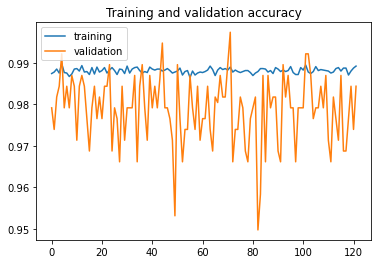

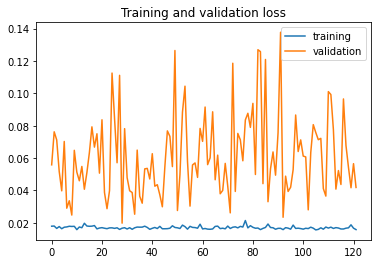

In [98]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [99]:
model.evaluate(test_ds)

34/34 [==============================] - 2s 43ms/step - loss: 1.6821 - accuracy: 0.7564


[1.682074785232544, 0.7564282417297363]

In [92]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.figure(figsize=(23,23))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[28 29 34 15 21 44 40 26]
 [35 18 40  6 27 33 27 23]
 [46 29 51 22 48 50 37 37]
 [13 10 15  6  9 28 19 12]
 [39 29 32 13 28 46 46 31]
 [44 37 45 21 40 48 55 59]
 [42 32 46 13 51 49 46 36]
 [41 32 46 20 37 54 55 48]]
[[28 29 34 15 21 44 40 26]
 [35 18 40  6 27 33 27 23]
 [46 29 51 22 48 50 37 37]
 [13 10 15  6  9 28 19 12]
 [39 29 32 13 28 46 46 31]
 [44 37 45 21 40 48 55 59]
 [42 32 46 13 51 49 46 36]
 [41 32 46 20 37 54 55 48]]


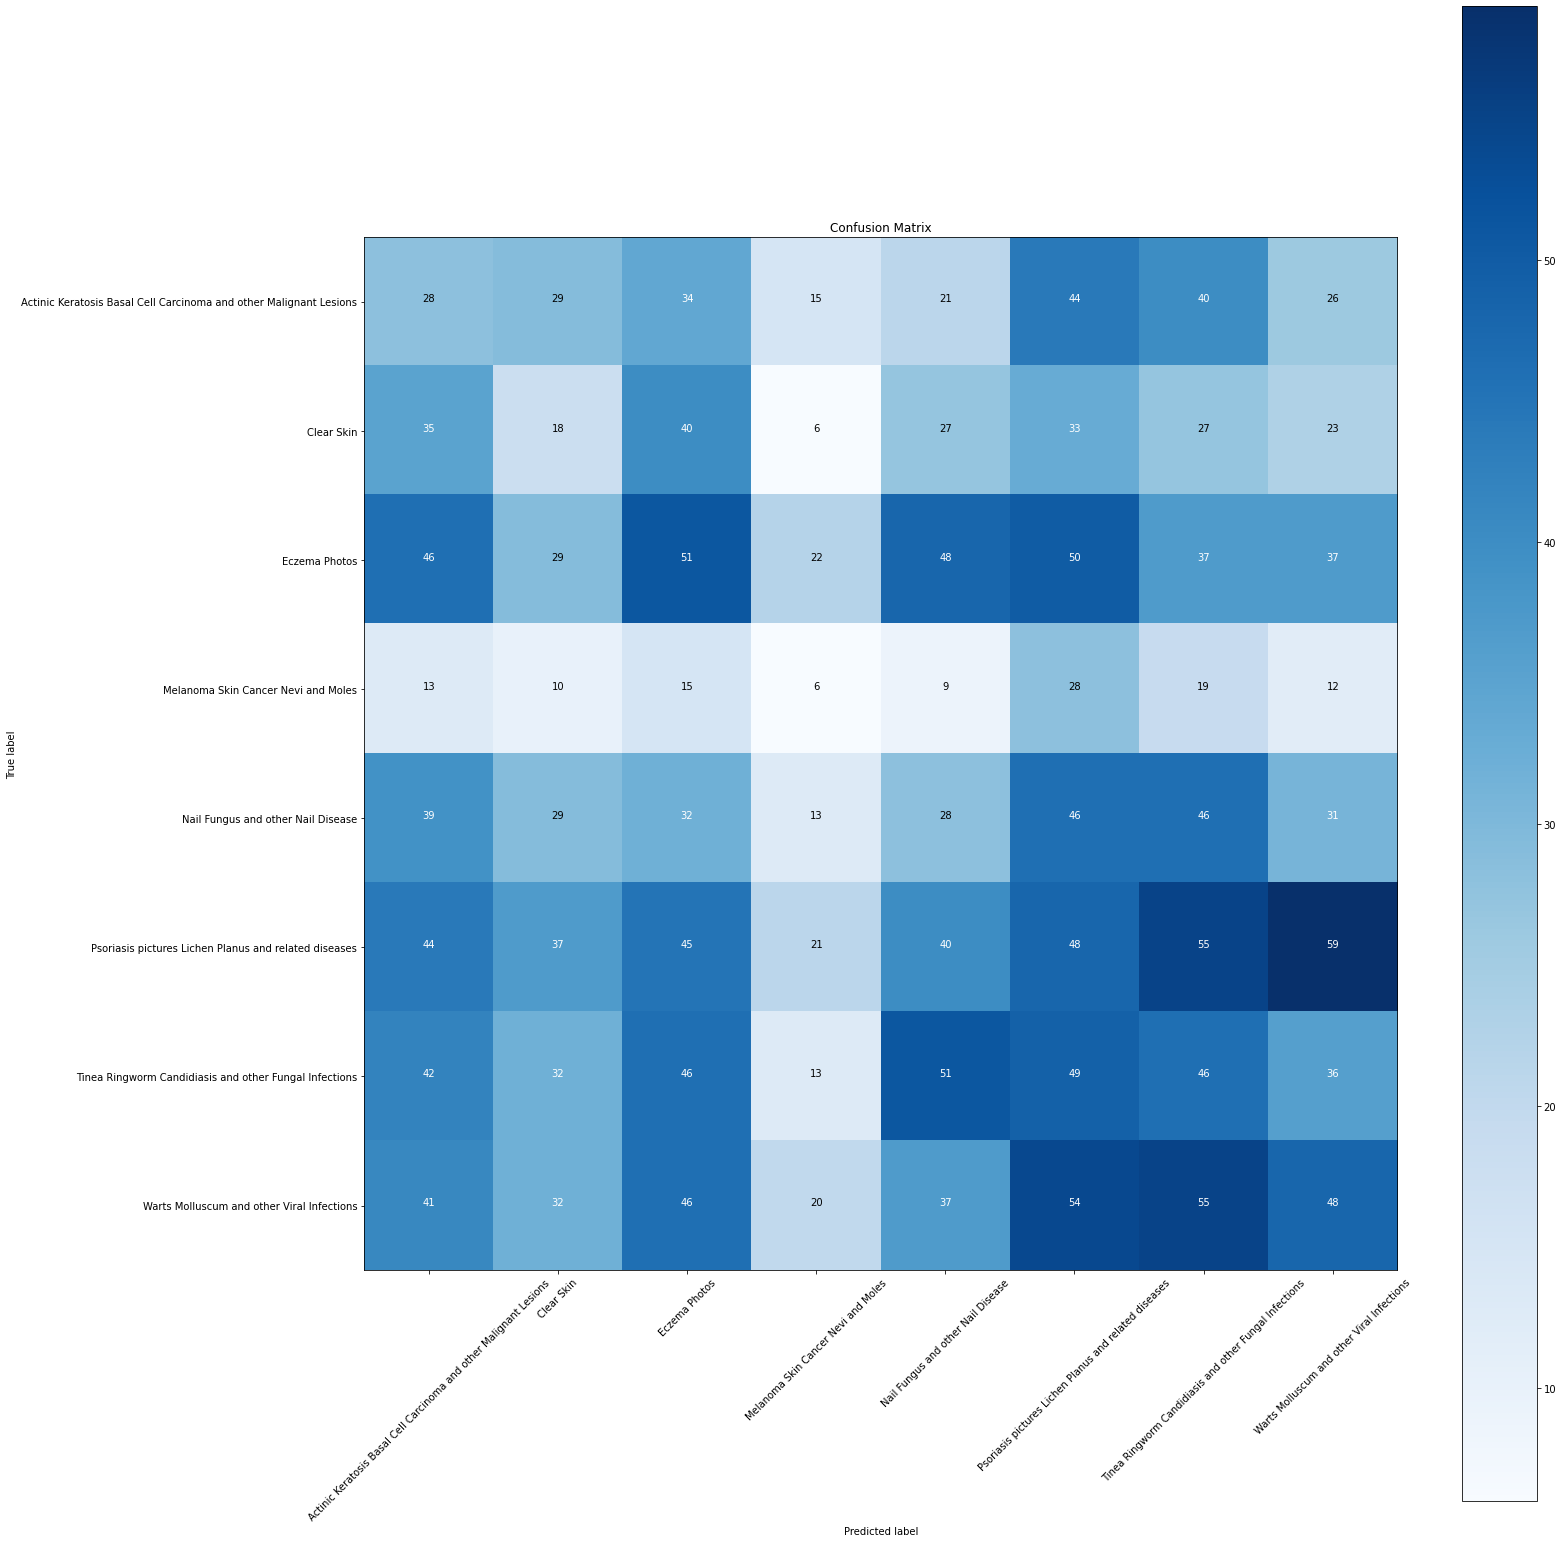

In [93]:
from sklearn.metrics import confusion_matrix


y_pred = model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
conf=confusion_matrix(predicted_categories, true_categories)
plot_confusion_matrix(conf, class_names, title='Confusion Matrix')
print(conf)

In [729]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflmodel = converter.convert()
file = open( 'C:\\Users\\Lenovo\\uni\\GRAD PROJECT\\yourmodel.tflite' , 'wb' ) 
file.write( tflmodel )

INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmp_s85q_4d\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmp_s85q_4d\assets


44424924

In [90]:
model.evaluate_tflite('C:\\Users\\Lenovo\\uni\\GRAD PROJECT\\yourmodel.tflite', test_data)

AttributeError: 'Functional' object has no attribute 'evaluate_tflite'

In [356]:
model.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128_input   [(None, 128, 128, 3)]    0         
 (InputLayer)                                                    
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 2, 2, 1280)       0         
 g2D)                                                            
                                                                 
 flatten_43 (Flatten)        (None, 5120)              0         
                                                                 
 dense_132 (Dense)           (None, 128)               655488    
                                                          

In [89]:
model.save('C:\\Users\\Lenovo\\uni\\GRAD PROJECT\\seventySeven') 

INFO:tensorflow:Assets written to: C:\Users\Lenovo\uni\GRAD PROJECT\seventySeven\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\uni\GRAD PROJECT\seventySeven\assets


In [91]:
print(np.shape(test_ds))

()


In [26]:
model = keras.models.load_model("C:\\Users\\Lenovo\\uni\\GRAD PROJECT\\seventy")

In [40]:
image1 = tf.keras.preprocessing.image.load_img(
    r"C:\Users\Lenovo\uni\GRAD PROJECT\dermnet1\test\Clear Skin\0076.jpg" 
,target_size=(128,128))
input_arr = tf.keras.preprocessing.image.img_to_array(image1)
input_arr = np.array([input_arr])  # Convert single image to a batch.
label =model.predict(input_arr)


In [44]:
print(label)

[[8.0279942e-06 9.9913400e-01 3.2359693e-09 4.9342576e-04 3.1873825e-04
  4.5624914e-05 9.2599672e-10 1.9052007e-07]]


## WITH DATAGEN

In [176]:
fig = plt.figure(figsize=(4, 4))
for index, image in enumerate(next(train_generator)):
    ax = plt.subplot(128,128, index + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image)
plt.show()

TypeError: Invalid shape (128, 128, 128, 3) for image data

In [68]:
!pip install scikit-learn

In [92]:
from sklearn.metrics import confusion_matrix

predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  maxi = np.max(model.predict(x))  
  predictions = np.concatenate([predictions,maxi ])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

model.summary()

# **Classification using SVM**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc=SVC()
x = base_model.output
prediction = tf.keras.layers.Flatten()(x)
model_svm = Model(inputs=base_model.input, outputs=prediction)
model_svm.summary()
block4_pool_features = model.predict(train_ds)
block4_pool_features.shape
# svc.fit(X_train,y_train)
# y_pred=svc.predict(X_test)

In [ ]:
labels =  np.array([0])
for x, y in train_dataset:
  #predictions = np.concatenate([predictions, model.predict_classes(x)])abs
    #print(len(labels))
    #print(y.numpy().shape)
    labels = np.column_stack([labels, np.argmax(y.numpy(), axis=-1)])
    


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
svm = LinearSVC()
#block4_pool_features.shape()
#(labels[1])
svm.fit(block4_pool_features,labels[-1])
preds_train = svm.predict(block4_pool_features)
preds_test = svm.predict(block4_pool_features_test)
accuracy_score(y, preds_train), accuracy_score(y_test, preds_test)